<a href="https://colab.research.google.com/github/alexiej/laboratory/blob/master/30_00_GAN_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import

In [0]:
%tensorflow_version 2.x
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio

import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

print("Tensorflow version: ", tf.__version__)
print("Pytorch version: ", torch.__version__)
print("GPU ON: ", torch.cuda.is_available())
 
!nvidia-smi

TensorFlow 2.x selected.
Tensorflow version:  2.1.0
Pytorch version:  1.4.0
GPU ON:  True
Thu Mar  5 08:40:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     7W /  75W |     10MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------

# 1.0 GAN Info

Article: https://towardsdatascience.com/image-to-image-translation-using-cyclegan-model-d58cfff04755


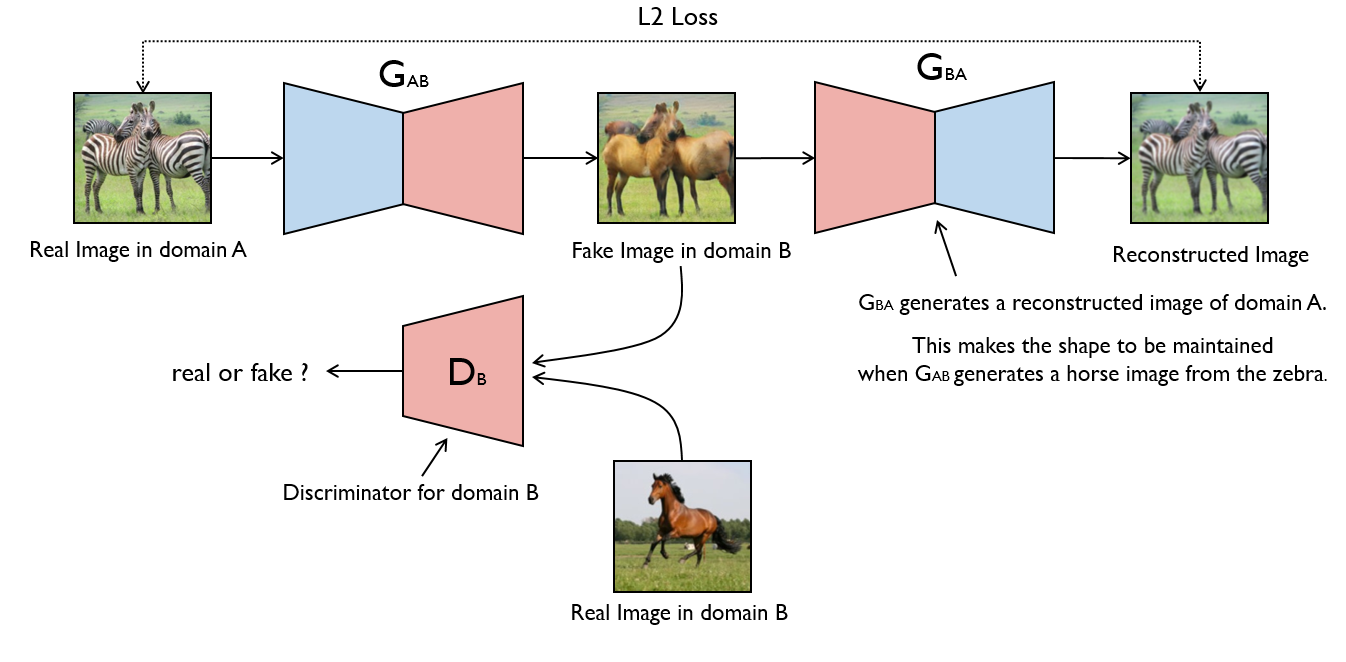

* `D_x` — Identifies training images from domain X as real and translated images from domain Y to domain X as fake.
* `D_y` — Identifies training images from domain X as real and translated images from domain Y to domain X as fake.
* `G_xtoy` — Translates images from domain X to domain Y.
* `G_ytox` — Translates images from domain Y to domain X.


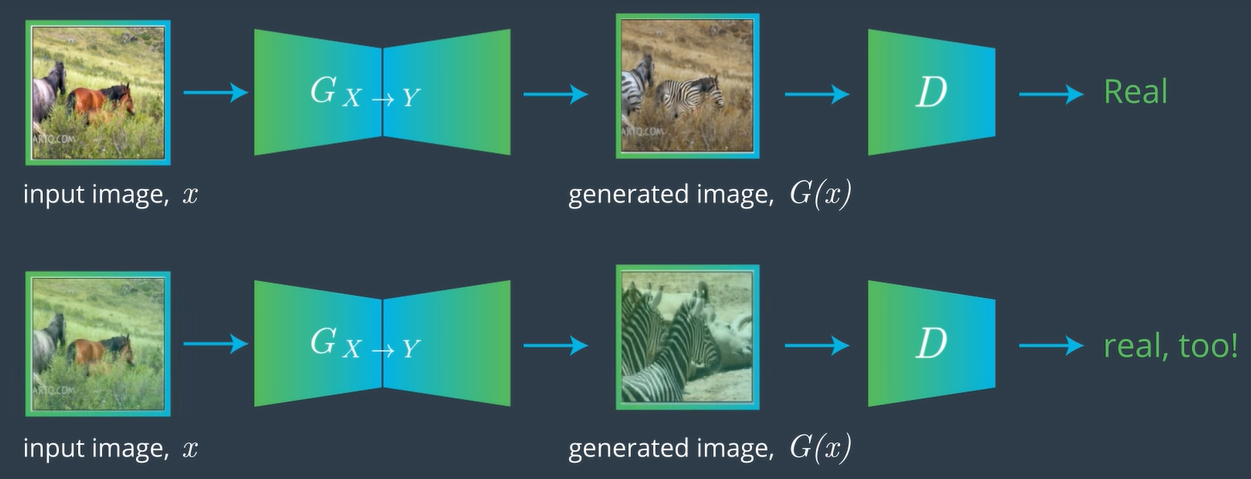

## 1.1 Pix2Pix GAN

Pix2Px generative Adversarial Network

https://machinelearningmastery.com/a-gentle-introduction-to-pix2pix-generative-adversarial-network/

# 2.0 DATA LOADER

In [0]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
!unzip -o -q summer2winter-yosemite.zip

--2020-03-05 08:40:58--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.82.75
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.82.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133783376 (128M) [application/zip]
Saving to: ‘summer2winter-yosemite.zip’

summer2winter-yosem 100%[===================>] 127.58M  14.0MB/s    in 10s     

2020-03-05 08:41:10 (12.2 MB/s) - ‘summer2winter-yosemite.zip’ saved [133783376/133783376]



In [0]:
def get_data_loader(image_type, image_dir='summer2winter_yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [0]:
# Create train and test dataloaders for images from the two domains X and Y
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

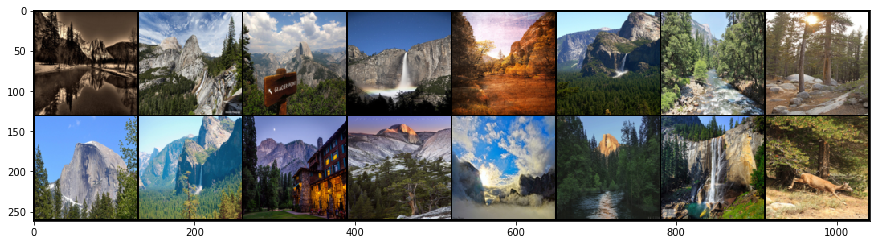

In [0]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(15, 8))
imshow(torchvision.utils.make_grid(images))

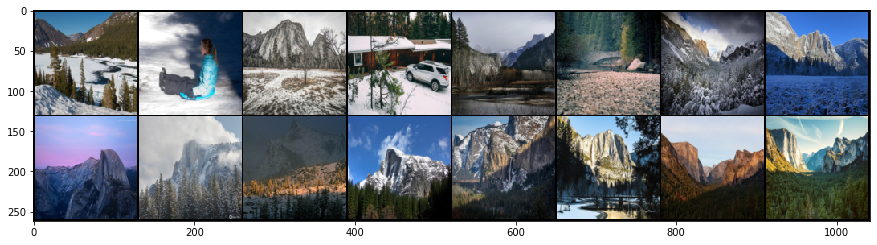

In [0]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(15,8))
imshow(torchvision.utils.make_grid(images))

## 2.1 SCALING IMAGE

In [0]:

# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0118)
Max:  tensor(0.9569)


In [0]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x


# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9765)
Scaled max:  tensor(0.9137)


# 3.0 MODEL

## 3.1 Discriminator (D)

In [0]:

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, 
                           out_channels=out_channels, 
                           kernel_size=kernel_size, 
                           stride=stride, padding=padding, 
                           bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)
    

class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        self.layer_1 = conv(3,conv_dim,4,batch_norm = False)
        self.layer_2 = conv(conv_dim,conv_dim*2,4)
        self.layer_3 = conv(conv_dim*2,conv_dim*4,4)
        self.layer_4 = conv(conv_dim*4,conv_dim*8,4)
        self.layer_5 = conv(conv_dim*8,1,4,1,batch_norm = False)

    def forward(self, x):
        # define feedforward behavior
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        x = F.relu(self.layer_4(x))
        
        x = self.layer_5(x)
        return x

## 3.2 CycleGenerator (G)

In [0]:
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs  
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        self.layer_1 = conv(conv_dim,conv_dim,3,1,1,batch_norm = True)
        self.layer_2 = conv(conv_dim,conv_dim,3,1,1,batch_norm = True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.layer_1(x))
        out_2 = x + self.layer_2(out_1)
        
        return out_2

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)
    
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        self.layer_1 = conv(3,conv_dim,4)
        self.layer_2 = conv(conv_dim,conv_dim*2,4)
        self.layer_3 = conv(conv_dim*2,conv_dim*4,4)
        # 2. Define the resnet part of the generator
        layers = []
        for n in range(n_res_blocks):
            layers.append(ResidualBlock(conv_dim*4))
        self.res_blocks = nn.Sequential(*layers)
        # 3. Define the decoder part of the generator
        self.layer_4 = deconv(conv_dim*4,conv_dim*2,4)
        self.layer_5 = deconv(conv_dim*2,conv_dim,4)
        self.layer_6 = deconv(conv_dim,3,4,batch_norm = False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        
        out = F.relu(self.layer_1(x))
        out = F.relu(self.layer_2(out))
        out = F.relu(self.layer_3(out))
        
        out = self.res_blocks(out)
        
        out = F.relu(self.layer_4(out))
        out = F.relu(self.layer_5(out))
        out = F.tanh(self.layer_6(out))
        
        return out

## 3.3 Create model (G_XtoY, G_YtoX, D_X, D_Y)

In [0]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(g_conv_dim,n_res_blocks)
    G_YtoX = CycleGenerator(g_conv_dim,n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(d_conv_dim)
    D_Y = Discriminator(d_conv_dim)
    

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [0]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


In [0]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (layer_1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

# 4.0 Loss

In [0]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out - 1)**2)

    
def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # return weighted loss
    loss = torch.mean(torch.abs(real_im - reconstructed_im))
    return loss*lambda_weight

# 5.0 Optimizer

In [0]:
# hyperparams for Adam optimizers
import torch.optim as optim

lr= 0.0002
beta1= 0.5
beta2= 0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

# 6.0 Helper funtions for images

In [0]:
# helper functions for saving sample data and models
!mkdir samples_cyclegan

# import data loading libraries
import os
import pdb
import pickle
import argparse

import warnings
warnings.filterwarnings("ignore")

# import torch
import torch


# numpy & scipy imports
import numpy as np
import scipy
import scipy.misc


def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan'):
    """Saves the parameters of both generators G_YtoX, G_XtoY and discriminators D_X, D_Y.
        """
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(checkpoint_dir, 'G_YtoX.pkl')
    D_X_path = os.path.join(checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(checkpoint_dir, 'D_Y.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)


def merge_images(sources, targets, batch_size=16):
    """Creates a grid consisting of pairs of columns, where the first column in
        each pair contains images source images and the second column in each pair
        contains images generated by the CycleGAN from the corresponding images in
        the first column.
        """
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged
    

def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan'):
    """Saves samples from both generators X->Y and Y->X.
        """
    # move input data to correct device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))
    
    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)
    
    merged = merge_images(X, fake_Y, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    imageio.imsave(path, merged)
    print('Saved {}'.format(path))
    
    merged = merge_images(Y, fake_X, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    imageio.imsave(path, merged)
    print('Saved {}'.format(path))

# 7.0 Train

In [0]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # 1. Compute the discriminator losses on real images
        d_x_optimizer.zero_grad()
        real_D_loss = real_mse_loss(D_X(images_X))
        # 3. Compute the fake loss for D_X
        fake_D_loss = fake_mse_loss(D_X(G_YtoX(images_Y)))
        # 4. Compute the total loss and perform backprop
        d_x_loss = real_D_loss + fake_D_loss
        d_x_loss.backward()
        d_x_optimizer.step()
        
        ##   Second: D_Y, real and fake loss components   ##
        d_y_optimizer.zero_grad()
        real_D_y_loss = real_mse_loss(D_Y(images_Y))
        
        fake_D_y_loss = fake_mse_loss(D_Y(G_XtoY(images_X)))
        
        d_y_loss = real_D_y_loss + fake_D_y_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()
        # 1. Generate fake images that look like domain X based on real images in domain Y
        out_1 = G_YtoX(images_Y)
        # 2. Compute the generator loss based on domain X
        loss_1 = real_mse_loss(D_X(out_1))
        # 3. Create a reconstructed y
        out_2 = G_XtoY(out_1)
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        loss_2 = cycle_consistency_loss(real_im = images_Y, reconstructed_im = out_2, lambda_weight=10)

        ##    Second: generate fake Y images and reconstructed X images    ##
        out_3 = G_XtoY(images_X)
        # 5. Add up all generator and reconstructed losses and perform backprop
        loss_3 = real_mse_loss(D_Y(out_3))
        out_4 = G_YtoX(out_3)
        loss_4 =  cycle_consistency_loss(real_im = images_X, reconstructed_im = out_4, lambda_weight=10)

        g_total_loss = loss_1 + loss_2 + loss_3 + loss_4
        g_total_loss.backward()
        g_optimizer.step()
        
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses

In [0]:

n_epochs = 5000 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(dataloader_X, 
                       dataloader_Y, 
                       test_dataloader_X, test_dataloader_Y,
                       n_epochs=n_epochs)

Epoch [   10/ 5000] | d_X_loss: 0.4238 | d_Y_loss: 0.3994 | g_total_loss: 10.1172
Epoch [   20/ 5000] | d_X_loss: 0.3372 | d_Y_loss: 0.3333 | g_total_loss: 8.4290
Epoch [   30/ 5000] | d_X_loss: 0.5062 | d_Y_loss: 0.2941 | g_total_loss: 7.4649
Epoch [   40/ 5000] | d_X_loss: 0.6749 | d_Y_loss: 0.2246 | g_total_loss: 7.4975
Epoch [   50/ 5000] | d_X_loss: 0.5223 | d_Y_loss: 0.3975 | g_total_loss: 5.5458
Epoch [   60/ 5000] | d_X_loss: 0.4862 | d_Y_loss: 0.3594 | g_total_loss: 5.8032
Epoch [   70/ 5000] | d_X_loss: 0.4285 | d_Y_loss: 0.3314 | g_total_loss: 5.2779
Epoch [   80/ 5000] | d_X_loss: 0.3505 | d_Y_loss: 0.6065 | g_total_loss: 4.9878
Epoch [   90/ 5000] | d_X_loss: 0.4565 | d_Y_loss: 0.3379 | g_total_loss: 4.9700


Epoch [  100/ 5000] | d_X_loss: 0.5125 | d_Y_loss: 0.3045 | g_total_loss: 5.1167


Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/ 5000] | d_X_loss: 0.1389 | d_Y_loss: 0.6667 | g_total_loss: 5.1166
Epoch [  120/ 5000] | d_X_loss: 0.3233 | d_Y_loss: 0.3746 | g_total_loss: 5.3200
Epoch [  130/ 5000] | d_X_loss: 0.4094 | d_Y_loss: 0.3935 | g_total_loss: 4.7939
Epoch [  140/ 5000] | d_X_loss: 0.1576 | d_Y_loss: 0.3206 | g_total_loss: 5.4382
Epoch [  150/ 5000] | d_X_loss: 0.4502 | d_Y_loss: 0.3805 | g_total_loss: 4.3673
Epoch [  160/ 5000] | d_X_loss: 0.3486 | d_Y_loss: 0.3402 | g_total_loss: 5.0639
Epoch [  170/ 5000] | d_X_loss: 0.2603 | d_Y_loss: 0.5589 | g_total_loss: 4.6628
Epoch [  180/ 5000] | d_X_loss: 0.4800 | d_Y_loss: 0.4106 | g_total_loss: 4.8468
Epoch [  190/ 5000] | d_X_loss: 0.4882 | d_Y_loss: 0.3214 | g_total_loss: 4.5769


Epoch [  200/ 5000] | d_X_loss: 0.2667 | d_Y_loss: 0.6086 | g_total_loss: 5.0448


Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/ 5000] | d_X_loss: 0.5345 | d_Y_loss: 0.3671 | g_total_loss: 4.5219
Epoch [  220/ 5000] | d_X_loss: 0.3771 | d_Y_loss: 0.3006 | g_total_loss: 4.3191
Epoch [  230/ 5000] | d_X_loss: 0.3441 | d_Y_loss: 0.5130 | g_total_loss: 4.4302
Epoch [  240/ 5000] | d_X_loss: 0.2075 | d_Y_loss: 0.4955 | g_total_loss: 4.8782
Epoch [  250/ 5000] | d_X_loss: 0.4805 | d_Y_loss: 0.3394 | g_total_loss: 4.4678
Epoch [  260/ 5000] | d_X_loss: 0.2990 | d_Y_loss: 0.3623 | g_total_loss: 4.6291
Epoch [  270/ 5000] | d_X_loss: 0.5638 | d_Y_loss: 0.4229 | g_total_loss: 3.3488
Epoch [  280/ 5000] | d_X_loss: 0.4386 | d_Y_loss: 0.2614 | g_total_loss: 4.5488
Epoch [  290/ 5000] | d_X_loss: 0.3916 | d_Y_loss: 0.6573 | g_total_loss: 4.0394


Epoch [  300/ 5000] | d_X_loss: 0.3892 | d_Y_loss: 0.4906 | g_total_loss: 4.7804


Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/ 5000] | d_X_loss: 0.3028 | d_Y_loss: 0.4524 | g_total_loss: 4.9819
Epoch [  320/ 5000] | d_X_loss: 0.2404 | d_Y_loss: 0.3811 | g_total_loss: 5.7267
Epoch [  330/ 5000] | d_X_loss: 0.4318 | d_Y_loss: 0.4751 | g_total_loss: 4.2852
Epoch [  340/ 5000] | d_X_loss: 0.4305 | d_Y_loss: 0.5954 | g_total_loss: 4.6590
Epoch [  350/ 5000] | d_X_loss: 0.3508 | d_Y_loss: 0.5489 | g_total_loss: 5.1094
Epoch [  360/ 5000] | d_X_loss: 0.3544 | d_Y_loss: 0.3813 | g_total_loss: 4.1699
Epoch [  370/ 5000] | d_X_loss: 0.4401 | d_Y_loss: 0.4124 | g_total_loss: 4.5507
Epoch [  380/ 5000] | d_X_loss: 0.3575 | d_Y_loss: 0.5763 | g_total_loss: 4.1312
Epoch [  390/ 5000] | d_X_loss: 0.8790 | d_Y_loss: 0.3456 | g_total_loss: 3.5112


Epoch [  400/ 5000] | d_X_loss: 0.3790 | d_Y_loss: 0.4918 | g_total_loss: 3.8402


Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/ 5000] | d_X_loss: 0.3778 | d_Y_loss: 0.4011 | g_total_loss: 5.0082
Epoch [  420/ 5000] | d_X_loss: 0.3043 | d_Y_loss: 0.2886 | g_total_loss: 4.4102
Epoch [  430/ 5000] | d_X_loss: 0.5018 | d_Y_loss: 0.3142 | g_total_loss: 5.2060
Epoch [  440/ 5000] | d_X_loss: 0.6599 | d_Y_loss: 0.3674 | g_total_loss: 4.4199
Epoch [  450/ 5000] | d_X_loss: 0.5826 | d_Y_loss: 0.5221 | g_total_loss: 4.5059
Epoch [  460/ 5000] | d_X_loss: 0.3529 | d_Y_loss: 0.5726 | g_total_loss: 4.0305
Epoch [  470/ 5000] | d_X_loss: 0.3038 | d_Y_loss: 0.4299 | g_total_loss: 4.4439
Epoch [  480/ 5000] | d_X_loss: 0.3588 | d_Y_loss: 0.3963 | g_total_loss: 4.5967
Epoch [  490/ 5000] | d_X_loss: 0.4130 | d_Y_loss: 0.8794 | g_total_loss: 6.0007


Epoch [  500/ 5000] | d_X_loss: 0.3552 | d_Y_loss: 0.4226 | g_total_loss: 4.5404


Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/ 5000] | d_X_loss: 0.2602 | d_Y_loss: 0.3783 | g_total_loss: 4.7373
Epoch [  520/ 5000] | d_X_loss: 0.2910 | d_Y_loss: 0.4406 | g_total_loss: 5.5506
Epoch [  530/ 5000] | d_X_loss: 0.2684 | d_Y_loss: 0.3331 | g_total_loss: 4.6221
Epoch [  540/ 5000] | d_X_loss: 0.4950 | d_Y_loss: 0.4016 | g_total_loss: 4.3317
Epoch [  550/ 5000] | d_X_loss: 0.3335 | d_Y_loss: 0.4013 | g_total_loss: 3.7947
Epoch [  560/ 5000] | d_X_loss: 0.4326 | d_Y_loss: 0.3684 | g_total_loss: 4.1212
Epoch [  570/ 5000] | d_X_loss: 0.5035 | d_Y_loss: 0.4393 | g_total_loss: 4.2009
Epoch [  580/ 5000] | d_X_loss: 0.3361 | d_Y_loss: 0.4341 | g_total_loss: 4.0114
Epoch [  590/ 5000] | d_X_loss: 0.2974 | d_Y_loss: 0.6280 | g_total_loss: 4.0062


Epoch [  600/ 5000] | d_X_loss: 0.3764 | d_Y_loss: 0.4933 | g_total_loss: 4.4050


Saved samples_cyclegan/sample-000600-X-Y.png
Saved samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/ 5000] | d_X_loss: 0.2778 | d_Y_loss: 0.4129 | g_total_loss: 4.2295
Epoch [  620/ 5000] | d_X_loss: 0.4543 | d_Y_loss: 0.3963 | g_total_loss: 4.6980
Epoch [  630/ 5000] | d_X_loss: 0.2659 | d_Y_loss: 0.3468 | g_total_loss: 4.3780
Epoch [  640/ 5000] | d_X_loss: 0.2630 | d_Y_loss: 0.3670 | g_total_loss: 4.5454
Epoch [  650/ 5000] | d_X_loss: 0.4067 | d_Y_loss: 0.5416 | g_total_loss: 4.2374
Epoch [  660/ 5000] | d_X_loss: 0.2695 | d_Y_loss: 0.3569 | g_total_loss: 3.9264
Epoch [  670/ 5000] | d_X_loss: 0.3297 | d_Y_loss: 0.4715 | g_total_loss: 4.4603
Epoch [  680/ 5000] | d_X_loss: 0.3847 | d_Y_loss: 0.4187 | g_total_loss: 5.7589
Epoch [  690/ 5000] | d_X_loss: 0.2589 | d_Y_loss: 0.6035 | g_total_loss: 4.7994


Epoch [  700/ 5000] | d_X_loss: 0.3699 | d_Y_loss: 0.4140 | g_total_loss: 4.0283


Saved samples_cyclegan/sample-000700-X-Y.png
Saved samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/ 5000] | d_X_loss: 0.3969 | d_Y_loss: 0.4149 | g_total_loss: 3.9189
Epoch [  720/ 5000] | d_X_loss: 0.3498 | d_Y_loss: 0.3374 | g_total_loss: 4.3196
Epoch [  730/ 5000] | d_X_loss: 0.4047 | d_Y_loss: 0.5825 | g_total_loss: 3.8530
Epoch [  740/ 5000] | d_X_loss: 0.3383 | d_Y_loss: 0.2457 | g_total_loss: 3.9306
Epoch [  750/ 5000] | d_X_loss: 0.3033 | d_Y_loss: 0.3532 | g_total_loss: 4.6318
Epoch [  760/ 5000] | d_X_loss: 0.2798 | d_Y_loss: 0.3838 | g_total_loss: 4.3228
Epoch [  770/ 5000] | d_X_loss: 0.2717 | d_Y_loss: 0.3328 | g_total_loss: 3.8161
Epoch [  780/ 5000] | d_X_loss: 0.1908 | d_Y_loss: 0.3031 | g_total_loss: 4.0022
Epoch [  790/ 5000] | d_X_loss: 0.5348 | d_Y_loss: 0.6291 | g_total_loss: 4.0199


Epoch [  800/ 5000] | d_X_loss: 0.4025 | d_Y_loss: 0.4643 | g_total_loss: 3.9744


Saved samples_cyclegan/sample-000800-X-Y.png
Saved samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/ 5000] | d_X_loss: 0.1791 | d_Y_loss: 0.3132 | g_total_loss: 4.2010
Epoch [  820/ 5000] | d_X_loss: 0.2244 | d_Y_loss: 0.4273 | g_total_loss: 4.5480
Epoch [  830/ 5000] | d_X_loss: 0.2294 | d_Y_loss: 0.4790 | g_total_loss: 5.1722
Epoch [  840/ 5000] | d_X_loss: 0.7704 | d_Y_loss: 0.3692 | g_total_loss: 3.7698
Epoch [  850/ 5000] | d_X_loss: 0.2795 | d_Y_loss: 0.2369 | g_total_loss: 4.5377
Epoch [  860/ 5000] | d_X_loss: 0.2559 | d_Y_loss: 0.3756 | g_total_loss: 3.7144
Epoch [  870/ 5000] | d_X_loss: 0.2935 | d_Y_loss: 0.4178 | g_total_loss: 4.3363
Epoch [  880/ 5000] | d_X_loss: 0.5615 | d_Y_loss: 0.3420 | g_total_loss: 4.3522
Epoch [  890/ 5000] | d_X_loss: 0.3748 | d_Y_loss: 0.3698 | g_total_loss: 4.3230


Epoch [  900/ 5000] | d_X_loss: 0.2405 | d_Y_loss: 0.3793 | g_total_loss: 3.5764


Saved samples_cyclegan/sample-000900-X-Y.png
Saved samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/ 5000] | d_X_loss: 0.2988 | d_Y_loss: 0.5098 | g_total_loss: 4.7131
Epoch [  920/ 5000] | d_X_loss: 0.2224 | d_Y_loss: 0.3497 | g_total_loss: 3.9409
Epoch [  930/ 5000] | d_X_loss: 0.2391 | d_Y_loss: 0.2992 | g_total_loss: 3.9334
Epoch [  940/ 5000] | d_X_loss: 0.3803 | d_Y_loss: 0.4654 | g_total_loss: 4.2406
Epoch [  950/ 5000] | d_X_loss: 0.4621 | d_Y_loss: 0.4165 | g_total_loss: 5.1876
Epoch [  960/ 5000] | d_X_loss: 0.2875 | d_Y_loss: 0.3142 | g_total_loss: 3.6431
Epoch [  970/ 5000] | d_X_loss: 0.3403 | d_Y_loss: 0.3709 | g_total_loss: 3.2698
Epoch [  980/ 5000] | d_X_loss: 0.1695 | d_Y_loss: 0.2280 | g_total_loss: 4.2915
Epoch [  990/ 5000] | d_X_loss: 0.2193 | d_Y_loss: 0.3833 | g_total_loss: 3.9442


Epoch [ 1000/ 5000] | d_X_loss: 0.3801 | d_Y_loss: 0.3242 | g_total_loss: 5.0830


Saved samples_cyclegan/sample-001000-X-Y.png
Saved samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/ 5000] | d_X_loss: 0.4214 | d_Y_loss: 0.3055 | g_total_loss: 4.1825
Epoch [ 1020/ 5000] | d_X_loss: 0.4564 | d_Y_loss: 0.2695 | g_total_loss: 4.8405
Epoch [ 1030/ 5000] | d_X_loss: 0.4207 | d_Y_loss: 0.4150 | g_total_loss: 3.8843
Epoch [ 1040/ 5000] | d_X_loss: 0.2859 | d_Y_loss: 0.3911 | g_total_loss: 3.7550
Epoch [ 1050/ 5000] | d_X_loss: 0.1536 | d_Y_loss: 0.3398 | g_total_loss: 4.3388
Epoch [ 1060/ 5000] | d_X_loss: 0.2722 | d_Y_loss: 0.3653 | g_total_loss: 4.2877
Epoch [ 1070/ 5000] | d_X_loss: 0.2019 | d_Y_loss: 0.2577 | g_total_loss: 4.0914
Epoch [ 1080/ 5000] | d_X_loss: 0.2516 | d_Y_loss: 0.3519 | g_total_loss: 3.8867
Epoch [ 1090/ 5000] | d_X_loss: 0.2835 | d_Y_loss: 0.2759 | g_total_loss: 4.6392


Epoch [ 1100/ 5000] | d_X_loss: 0.1146 | d_Y_loss: 0.2957 | g_total_loss: 5.4471


Saved samples_cyclegan/sample-001100-X-Y.png
Saved samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/ 5000] | d_X_loss: 0.1808 | d_Y_loss: 0.8041 | g_total_loss: 5.7837
Epoch [ 1120/ 5000] | d_X_loss: 0.2218 | d_Y_loss: 0.3674 | g_total_loss: 4.7399
Epoch [ 1130/ 5000] | d_X_loss: 0.2683 | d_Y_loss: 0.3792 | g_total_loss: 3.8616
Epoch [ 1140/ 5000] | d_X_loss: 0.2908 | d_Y_loss: 0.4073 | g_total_loss: 4.1694
Epoch [ 1150/ 5000] | d_X_loss: 0.1954 | d_Y_loss: 0.2932 | g_total_loss: 3.9830
Epoch [ 1160/ 5000] | d_X_loss: 0.2685 | d_Y_loss: 0.8079 | g_total_loss: 3.2068
Epoch [ 1170/ 5000] | d_X_loss: 0.3414 | d_Y_loss: 0.3242 | g_total_loss: 3.3540
Epoch [ 1180/ 5000] | d_X_loss: 0.1516 | d_Y_loss: 0.3712 | g_total_loss: 3.9310
Epoch [ 1190/ 5000] | d_X_loss: 0.3444 | d_Y_loss: 0.3843 | g_total_loss: 4.1523


Epoch [ 1200/ 5000] | d_X_loss: 0.2535 | d_Y_loss: 0.5324 | g_total_loss: 3.5708


Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/ 5000] | d_X_loss: 0.2631 | d_Y_loss: 0.3075 | g_total_loss: 3.7268
Epoch [ 1220/ 5000] | d_X_loss: 0.2206 | d_Y_loss: 0.3169 | g_total_loss: 4.7827
Epoch [ 1230/ 5000] | d_X_loss: 0.3084 | d_Y_loss: 0.6305 | g_total_loss: 4.6429
Epoch [ 1240/ 5000] | d_X_loss: 0.1319 | d_Y_loss: 0.1392 | g_total_loss: 4.6263
Epoch [ 1250/ 5000] | d_X_loss: 0.1687 | d_Y_loss: 0.3210 | g_total_loss: 3.5456
Epoch [ 1260/ 5000] | d_X_loss: 0.5021 | d_Y_loss: 0.4106 | g_total_loss: 3.0128
Epoch [ 1270/ 5000] | d_X_loss: 0.2920 | d_Y_loss: 0.2937 | g_total_loss: 4.2492
Epoch [ 1280/ 5000] | d_X_loss: 0.0779 | d_Y_loss: 0.4856 | g_total_loss: 5.8534
Epoch [ 1290/ 5000] | d_X_loss: 0.1886 | d_Y_loss: 0.3430 | g_total_loss: 4.1535


Epoch [ 1300/ 5000] | d_X_loss: 0.4573 | d_Y_loss: 0.6883 | g_total_loss: 5.2133


Saved samples_cyclegan/sample-001300-X-Y.png
Saved samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/ 5000] | d_X_loss: 0.2604 | d_Y_loss: 0.3573 | g_total_loss: 3.9255
Epoch [ 1320/ 5000] | d_X_loss: 0.5646 | d_Y_loss: 0.3265 | g_total_loss: 3.8284
Epoch [ 1330/ 5000] | d_X_loss: 0.3344 | d_Y_loss: 0.4095 | g_total_loss: 4.0365
Epoch [ 1340/ 5000] | d_X_loss: 0.2716 | d_Y_loss: 0.4060 | g_total_loss: 4.0515
Epoch [ 1350/ 5000] | d_X_loss: 0.2193 | d_Y_loss: 0.2525 | g_total_loss: 4.1394
Epoch [ 1360/ 5000] | d_X_loss: 0.8483 | d_Y_loss: 0.2896 | g_total_loss: 4.3520
Epoch [ 1370/ 5000] | d_X_loss: 0.2067 | d_Y_loss: 0.2654 | g_total_loss: 4.3448
Epoch [ 1380/ 5000] | d_X_loss: 0.2330 | d_Y_loss: 0.2339 | g_total_loss: 4.9194
Epoch [ 1390/ 5000] | d_X_loss: 0.1429 | d_Y_loss: 0.3371 | g_total_loss: 5.4168


Epoch [ 1400/ 5000] | d_X_loss: 0.0683 | d_Y_loss: 0.2319 | g_total_loss: 4.6299


Saved samples_cyclegan/sample-001400-X-Y.png
Saved samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/ 5000] | d_X_loss: 0.4501 | d_Y_loss: 0.3358 | g_total_loss: 4.9150
Epoch [ 1420/ 5000] | d_X_loss: 0.2955 | d_Y_loss: 0.2803 | g_total_loss: 3.8618
Epoch [ 1430/ 5000] | d_X_loss: 0.2457 | d_Y_loss: 0.2765 | g_total_loss: 4.6920
Epoch [ 1440/ 5000] | d_X_loss: 0.3764 | d_Y_loss: 0.3283 | g_total_loss: 4.4737
Epoch [ 1450/ 5000] | d_X_loss: 0.1214 | d_Y_loss: 0.4142 | g_total_loss: 4.4923
Epoch [ 1460/ 5000] | d_X_loss: 0.2267 | d_Y_loss: 0.2738 | g_total_loss: 4.1257
Epoch [ 1470/ 5000] | d_X_loss: 0.3216 | d_Y_loss: 0.5238 | g_total_loss: 4.3643
Epoch [ 1480/ 5000] | d_X_loss: 0.2150 | d_Y_loss: 0.1911 | g_total_loss: 3.3649
Epoch [ 1490/ 5000] | d_X_loss: 0.1637 | d_Y_loss: 0.2469 | g_total_loss: 3.9116


Epoch [ 1500/ 5000] | d_X_loss: 0.4994 | d_Y_loss: 0.3164 | g_total_loss: 4.4978


Saved samples_cyclegan/sample-001500-X-Y.png
Saved samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/ 5000] | d_X_loss: 0.1880 | d_Y_loss: 0.2792 | g_total_loss: 4.2084
Epoch [ 1520/ 5000] | d_X_loss: 0.2243 | d_Y_loss: 0.2236 | g_total_loss: 3.8057
Epoch [ 1530/ 5000] | d_X_loss: 0.1249 | d_Y_loss: 0.2395 | g_total_loss: 3.8255
Epoch [ 1540/ 5000] | d_X_loss: 0.2813 | d_Y_loss: 0.4492 | g_total_loss: 4.6330
Epoch [ 1550/ 5000] | d_X_loss: 0.2718 | d_Y_loss: 0.4499 | g_total_loss: 3.6023
Epoch [ 1560/ 5000] | d_X_loss: 0.2667 | d_Y_loss: 0.3407 | g_total_loss: 4.2712
Epoch [ 1570/ 5000] | d_X_loss: 0.2275 | d_Y_loss: 0.2532 | g_total_loss: 4.5131
Epoch [ 1580/ 5000] | d_X_loss: 0.4969 | d_Y_loss: 0.2475 | g_total_loss: 3.3501
Epoch [ 1590/ 5000] | d_X_loss: 0.1950 | d_Y_loss: 0.3195 | g_total_loss: 4.3374


Epoch [ 1600/ 5000] | d_X_loss: 0.1950 | d_Y_loss: 0.2429 | g_total_loss: 3.7470


Saved samples_cyclegan/sample-001600-X-Y.png
Saved samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/ 5000] | d_X_loss: 0.1579 | d_Y_loss: 0.2259 | g_total_loss: 4.5680
Epoch [ 1620/ 5000] | d_X_loss: 0.1838 | d_Y_loss: 0.3998 | g_total_loss: 4.9433
Epoch [ 1630/ 5000] | d_X_loss: 0.2175 | d_Y_loss: 0.2316 | g_total_loss: 3.7386
Epoch [ 1640/ 5000] | d_X_loss: 0.2390 | d_Y_loss: 0.3635 | g_total_loss: 4.4847
Epoch [ 1650/ 5000] | d_X_loss: 0.1794 | d_Y_loss: 0.3625 | g_total_loss: 3.8259
Epoch [ 1660/ 5000] | d_X_loss: 0.0867 | d_Y_loss: 0.1980 | g_total_loss: 4.2338
Epoch [ 1670/ 5000] | d_X_loss: 0.1277 | d_Y_loss: 0.2080 | g_total_loss: 4.0992
Epoch [ 1680/ 5000] | d_X_loss: 0.2698 | d_Y_loss: 0.2175 | g_total_loss: 4.0479
Epoch [ 1690/ 5000] | d_X_loss: 0.9041 | d_Y_loss: 0.4408 | g_total_loss: 3.8079


Epoch [ 1700/ 5000] | d_X_loss: 0.2517 | d_Y_loss: 0.3653 | g_total_loss: 4.3246


Saved samples_cyclegan/sample-001700-X-Y.png
Saved samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/ 5000] | d_X_loss: 0.1321 | d_Y_loss: 0.2936 | g_total_loss: 3.9200
Epoch [ 1720/ 5000] | d_X_loss: 0.2295 | d_Y_loss: 0.1936 | g_total_loss: 4.2511
Epoch [ 1730/ 5000] | d_X_loss: 0.4824 | d_Y_loss: 0.2516 | g_total_loss: 4.4987
Epoch [ 1740/ 5000] | d_X_loss: 0.2564 | d_Y_loss: 0.2722 | g_total_loss: 3.7618
Epoch [ 1750/ 5000] | d_X_loss: 0.1656 | d_Y_loss: 0.2548 | g_total_loss: 3.7784
Epoch [ 1760/ 5000] | d_X_loss: 0.2439 | d_Y_loss: 0.3403 | g_total_loss: 3.3787
Epoch [ 1770/ 5000] | d_X_loss: 0.2676 | d_Y_loss: 1.6245 | g_total_loss: 4.0414
Epoch [ 1780/ 5000] | d_X_loss: 0.2795 | d_Y_loss: 0.3184 | g_total_loss: 4.3361
Epoch [ 1790/ 5000] | d_X_loss: 0.1747 | d_Y_loss: 0.3123 | g_total_loss: 3.9561


Epoch [ 1800/ 5000] | d_X_loss: 0.1848 | d_Y_loss: 0.2914 | g_total_loss: 4.1490


Saved samples_cyclegan/sample-001800-X-Y.png
Saved samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/ 5000] | d_X_loss: 0.2325 | d_Y_loss: 0.4147 | g_total_loss: 4.9052
Epoch [ 1820/ 5000] | d_X_loss: 0.3293 | d_Y_loss: 0.2630 | g_total_loss: 4.2698
Epoch [ 1830/ 5000] | d_X_loss: 0.1045 | d_Y_loss: 0.3447 | g_total_loss: 4.8223
Epoch [ 1840/ 5000] | d_X_loss: 0.2294 | d_Y_loss: 0.2717 | g_total_loss: 4.5792
Epoch [ 1850/ 5000] | d_X_loss: 0.4374 | d_Y_loss: 0.1977 | g_total_loss: 3.9302
Epoch [ 1860/ 5000] | d_X_loss: 0.1377 | d_Y_loss: 0.2342 | g_total_loss: 3.6330
Epoch [ 1870/ 5000] | d_X_loss: 0.6919 | d_Y_loss: 0.4185 | g_total_loss: 3.0610
Epoch [ 1880/ 5000] | d_X_loss: 0.3050 | d_Y_loss: 0.3482 | g_total_loss: 3.7408
Epoch [ 1890/ 5000] | d_X_loss: 0.2240 | d_Y_loss: 0.2293 | g_total_loss: 5.5161


Epoch [ 1900/ 5000] | d_X_loss: 0.0756 | d_Y_loss: 0.4345 | g_total_loss: 4.5778


Saved samples_cyclegan/sample-001900-X-Y.png
Saved samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/ 5000] | d_X_loss: 0.0493 | d_Y_loss: 0.2433 | g_total_loss: 3.6040
Epoch [ 1920/ 5000] | d_X_loss: 0.5556 | d_Y_loss: 0.3361 | g_total_loss: 2.8937
Epoch [ 1930/ 5000] | d_X_loss: 0.0797 | d_Y_loss: 0.1865 | g_total_loss: 3.9701
Epoch [ 1940/ 5000] | d_X_loss: 0.2064 | d_Y_loss: 0.2572 | g_total_loss: 3.6462
Epoch [ 1950/ 5000] | d_X_loss: 0.2211 | d_Y_loss: 0.2844 | g_total_loss: 3.4627
Epoch [ 1960/ 5000] | d_X_loss: 0.2282 | d_Y_loss: 0.3798 | g_total_loss: 5.0637
Epoch [ 1970/ 5000] | d_X_loss: 0.2300 | d_Y_loss: 0.1620 | g_total_loss: 4.1594
Epoch [ 1980/ 5000] | d_X_loss: 0.3248 | d_Y_loss: 0.2569 | g_total_loss: 3.6565
Epoch [ 1990/ 5000] | d_X_loss: 0.0905 | d_Y_loss: 1.0844 | g_total_loss: 2.9562


Epoch [ 2000/ 5000] | d_X_loss: 0.2522 | d_Y_loss: 0.2200 | g_total_loss: 5.3297


Saved samples_cyclegan/sample-002000-X-Y.png
Saved samples_cyclegan/sample-002000-Y-X.png
Epoch [ 2010/ 5000] | d_X_loss: 0.1946 | d_Y_loss: 0.2359 | g_total_loss: 4.3536
Epoch [ 2020/ 5000] | d_X_loss: 0.3112 | d_Y_loss: 0.1506 | g_total_loss: 4.4974
Epoch [ 2030/ 5000] | d_X_loss: 0.2255 | d_Y_loss: 0.2397 | g_total_loss: 4.3376
Epoch [ 2040/ 5000] | d_X_loss: 0.0663 | d_Y_loss: 0.2410 | g_total_loss: 5.4763
Epoch [ 2050/ 5000] | d_X_loss: 0.2163 | d_Y_loss: 0.1685 | g_total_loss: 3.9065
Epoch [ 2060/ 5000] | d_X_loss: 0.2765 | d_Y_loss: 0.2456 | g_total_loss: 3.3536
Epoch [ 2070/ 5000] | d_X_loss: 0.0936 | d_Y_loss: 0.1464 | g_total_loss: 4.3285
Epoch [ 2080/ 5000] | d_X_loss: 0.1905 | d_Y_loss: 0.2362 | g_total_loss: 3.7781
Epoch [ 2090/ 5000] | d_X_loss: 0.2791 | d_Y_loss: 0.1035 | g_total_loss: 4.5675


Epoch [ 2100/ 5000] | d_X_loss: 0.3958 | d_Y_loss: 0.3726 | g_total_loss: 3.7909


Saved samples_cyclegan/sample-002100-X-Y.png
Saved samples_cyclegan/sample-002100-Y-X.png
Epoch [ 2110/ 5000] | d_X_loss: 0.0494 | d_Y_loss: 0.1822 | g_total_loss: 3.6780
Epoch [ 2120/ 5000] | d_X_loss: 0.0959 | d_Y_loss: 0.1656 | g_total_loss: 4.1033
Epoch [ 2130/ 5000] | d_X_loss: 0.1798 | d_Y_loss: 0.2010 | g_total_loss: 4.9914
Epoch [ 2140/ 5000] | d_X_loss: 0.1190 | d_Y_loss: 0.9889 | g_total_loss: 3.6680
Epoch [ 2150/ 5000] | d_X_loss: 0.0722 | d_Y_loss: 0.3837 | g_total_loss: 4.1492
Epoch [ 2160/ 5000] | d_X_loss: 0.1979 | d_Y_loss: 0.4346 | g_total_loss: 3.5570
Epoch [ 2170/ 5000] | d_X_loss: 0.1495 | d_Y_loss: 0.4346 | g_total_loss: 3.3273
Epoch [ 2180/ 5000] | d_X_loss: 0.0961 | d_Y_loss: 0.3709 | g_total_loss: 4.2540
Epoch [ 2190/ 5000] | d_X_loss: 0.5529 | d_Y_loss: 0.3287 | g_total_loss: 2.7898


Epoch [ 2200/ 5000] | d_X_loss: 0.1996 | d_Y_loss: 0.2966 | g_total_loss: 4.7626


Saved samples_cyclegan/sample-002200-X-Y.png
Saved samples_cyclegan/sample-002200-Y-X.png
Epoch [ 2210/ 5000] | d_X_loss: 0.1547 | d_Y_loss: 0.2759 | g_total_loss: 4.0241
Epoch [ 2220/ 5000] | d_X_loss: 0.1432 | d_Y_loss: 0.2711 | g_total_loss: 4.1773
Epoch [ 2230/ 5000] | d_X_loss: 0.3226 | d_Y_loss: 0.2680 | g_total_loss: 2.9819
Epoch [ 2240/ 5000] | d_X_loss: 0.0558 | d_Y_loss: 0.2112 | g_total_loss: 4.1921
Epoch [ 2250/ 5000] | d_X_loss: 0.1126 | d_Y_loss: 0.2075 | g_total_loss: 3.9704
Epoch [ 2260/ 5000] | d_X_loss: 0.1431 | d_Y_loss: 0.2373 | g_total_loss: 4.4388
Epoch [ 2270/ 5000] | d_X_loss: 0.0434 | d_Y_loss: 0.2045 | g_total_loss: 4.3829
Epoch [ 2280/ 5000] | d_X_loss: 0.1511 | d_Y_loss: 0.1887 | g_total_loss: 4.3745
Epoch [ 2290/ 5000] | d_X_loss: 0.4454 | d_Y_loss: 0.2578 | g_total_loss: 3.2813


Epoch [ 2300/ 5000] | d_X_loss: 0.2222 | d_Y_loss: 0.3216 | g_total_loss: 3.1421


Saved samples_cyclegan/sample-002300-X-Y.png
Saved samples_cyclegan/sample-002300-Y-X.png
Epoch [ 2310/ 5000] | d_X_loss: 0.1042 | d_Y_loss: 0.1801 | g_total_loss: 4.5727
Epoch [ 2320/ 5000] | d_X_loss: 0.1335 | d_Y_loss: 0.1917 | g_total_loss: 3.6069
Epoch [ 2330/ 5000] | d_X_loss: 0.0878 | d_Y_loss: 0.1778 | g_total_loss: 4.2514
Epoch [ 2340/ 5000] | d_X_loss: 0.2892 | d_Y_loss: 0.2269 | g_total_loss: 4.7084
Epoch [ 2350/ 5000] | d_X_loss: 0.2537 | d_Y_loss: 0.2091 | g_total_loss: 4.0726
Epoch [ 2360/ 5000] | d_X_loss: 0.1712 | d_Y_loss: 0.2902 | g_total_loss: 3.9304
Epoch [ 2370/ 5000] | d_X_loss: 0.7036 | d_Y_loss: 0.1528 | g_total_loss: 3.4268
Epoch [ 2380/ 5000] | d_X_loss: 0.1432 | d_Y_loss: 0.0992 | g_total_loss: 5.1537
Epoch [ 2390/ 5000] | d_X_loss: 0.1335 | d_Y_loss: 0.2038 | g_total_loss: 4.4790


Epoch [ 2400/ 5000] | d_X_loss: 0.1001 | d_Y_loss: 0.1525 | g_total_loss: 3.3716


Saved samples_cyclegan/sample-002400-X-Y.png
Saved samples_cyclegan/sample-002400-Y-X.png
Epoch [ 2410/ 5000] | d_X_loss: 0.2724 | d_Y_loss: 0.2388 | g_total_loss: 3.8431
Epoch [ 2420/ 5000] | d_X_loss: 0.2313 | d_Y_loss: 0.1531 | g_total_loss: 4.0074
Epoch [ 2430/ 5000] | d_X_loss: 0.1927 | d_Y_loss: 0.2041 | g_total_loss: 3.8895
Epoch [ 2440/ 5000] | d_X_loss: 0.1515 | d_Y_loss: 0.4364 | g_total_loss: 5.7851
Epoch [ 2450/ 5000] | d_X_loss: 0.3217 | d_Y_loss: 0.1739 | g_total_loss: 3.6129
Epoch [ 2460/ 5000] | d_X_loss: 0.0588 | d_Y_loss: 0.5264 | g_total_loss: 3.6483
Epoch [ 2470/ 5000] | d_X_loss: 0.0801 | d_Y_loss: 0.1850 | g_total_loss: 3.7827
Epoch [ 2480/ 5000] | d_X_loss: 0.1602 | d_Y_loss: 0.1232 | g_total_loss: 4.0032
Epoch [ 2490/ 5000] | d_X_loss: 0.2659 | d_Y_loss: 0.1127 | g_total_loss: 3.8898


Epoch [ 2500/ 5000] | d_X_loss: 0.3527 | d_Y_loss: 0.3104 | g_total_loss: 8.2897


Saved samples_cyclegan/sample-002500-X-Y.png
Saved samples_cyclegan/sample-002500-Y-X.png
Epoch [ 2510/ 5000] | d_X_loss: 0.0989 | d_Y_loss: 0.2689 | g_total_loss: 3.5507
Epoch [ 2520/ 5000] | d_X_loss: 0.0481 | d_Y_loss: 0.1168 | g_total_loss: 4.5352
Epoch [ 2530/ 5000] | d_X_loss: 0.1718 | d_Y_loss: 0.1608 | g_total_loss: 4.6240
Epoch [ 2540/ 5000] | d_X_loss: 0.1678 | d_Y_loss: 0.1360 | g_total_loss: 4.2546
Epoch [ 2550/ 5000] | d_X_loss: 0.3254 | d_Y_loss: 0.7785 | g_total_loss: 5.5302
Epoch [ 2560/ 5000] | d_X_loss: 0.1245 | d_Y_loss: 0.2523 | g_total_loss: 3.7545
Epoch [ 2570/ 5000] | d_X_loss: 0.0567 | d_Y_loss: 0.1329 | g_total_loss: 4.1283
Epoch [ 2580/ 5000] | d_X_loss: 0.2979 | d_Y_loss: 0.2925 | g_total_loss: 3.8372
Epoch [ 2590/ 5000] | d_X_loss: 0.1201 | d_Y_loss: 0.1870 | g_total_loss: 3.9862


Epoch [ 2600/ 5000] | d_X_loss: 0.3153 | d_Y_loss: 0.1820 | g_total_loss: 5.0003


Saved samples_cyclegan/sample-002600-X-Y.png
Saved samples_cyclegan/sample-002600-Y-X.png
Epoch [ 2610/ 5000] | d_X_loss: 0.1352 | d_Y_loss: 0.2299 | g_total_loss: 4.6707
Epoch [ 2620/ 5000] | d_X_loss: 0.1061 | d_Y_loss: 0.2269 | g_total_loss: 3.8560
Epoch [ 2630/ 5000] | d_X_loss: 0.1927 | d_Y_loss: 0.2059 | g_total_loss: 4.4092
Epoch [ 2640/ 5000] | d_X_loss: 0.1139 | d_Y_loss: 0.2390 | g_total_loss: 3.7556
Epoch [ 2650/ 5000] | d_X_loss: 0.0730 | d_Y_loss: 0.1838 | g_total_loss: 4.2107
Epoch [ 2660/ 5000] | d_X_loss: 0.1712 | d_Y_loss: 0.1477 | g_total_loss: 3.9067
Epoch [ 2670/ 5000] | d_X_loss: 0.0593 | d_Y_loss: 0.1646 | g_total_loss: 4.5175
Epoch [ 2680/ 5000] | d_X_loss: 0.2128 | d_Y_loss: 0.3312 | g_total_loss: 4.1826
Epoch [ 2690/ 5000] | d_X_loss: 0.4222 | d_Y_loss: 0.1546 | g_total_loss: 3.7842


Epoch [ 2700/ 5000] | d_X_loss: 0.1859 | d_Y_loss: 0.1392 | g_total_loss: 4.6819


Saved samples_cyclegan/sample-002700-X-Y.png
Saved samples_cyclegan/sample-002700-Y-X.png
Epoch [ 2710/ 5000] | d_X_loss: 0.1322 | d_Y_loss: 0.1693 | g_total_loss: 4.3262
Epoch [ 2720/ 5000] | d_X_loss: 0.0698 | d_Y_loss: 0.1329 | g_total_loss: 4.4084
Epoch [ 2730/ 5000] | d_X_loss: 0.1149 | d_Y_loss: 0.3246 | g_total_loss: 4.2738
Epoch [ 2740/ 5000] | d_X_loss: 0.0779 | d_Y_loss: 0.1554 | g_total_loss: 4.1374
Epoch [ 2750/ 5000] | d_X_loss: 0.1640 | d_Y_loss: 0.2199 | g_total_loss: 3.6641
Epoch [ 2760/ 5000] | d_X_loss: 0.0666 | d_Y_loss: 0.2837 | g_total_loss: 4.3154
Epoch [ 2770/ 5000] | d_X_loss: 0.1773 | d_Y_loss: 0.0859 | g_total_loss: 3.9031
Epoch [ 2780/ 5000] | d_X_loss: 0.1011 | d_Y_loss: 0.1883 | g_total_loss: 3.6950
Epoch [ 2790/ 5000] | d_X_loss: 0.2476 | d_Y_loss: 0.1869 | g_total_loss: 3.3383


Epoch [ 2800/ 5000] | d_X_loss: 0.0580 | d_Y_loss: 0.1571 | g_total_loss: 4.2845


Saved samples_cyclegan/sample-002800-X-Y.png
Saved samples_cyclegan/sample-002800-Y-X.png
Epoch [ 2810/ 5000] | d_X_loss: 0.1589 | d_Y_loss: 0.3749 | g_total_loss: 4.3065
Epoch [ 2820/ 5000] | d_X_loss: 0.0683 | d_Y_loss: 0.1508 | g_total_loss: 4.6548
Epoch [ 2830/ 5000] | d_X_loss: 0.2023 | d_Y_loss: 0.1215 | g_total_loss: 4.4920
Epoch [ 2840/ 5000] | d_X_loss: 0.1698 | d_Y_loss: 0.1316 | g_total_loss: 3.8364
Epoch [ 2850/ 5000] | d_X_loss: 0.1931 | d_Y_loss: 0.1888 | g_total_loss: 4.5421
Epoch [ 2860/ 5000] | d_X_loss: 0.1508 | d_Y_loss: 0.2813 | g_total_loss: 5.1213
Epoch [ 2870/ 5000] | d_X_loss: 0.1160 | d_Y_loss: 0.1929 | g_total_loss: 4.6278
Epoch [ 2880/ 5000] | d_X_loss: 0.1247 | d_Y_loss: 0.1686 | g_total_loss: 3.9611
Epoch [ 2890/ 5000] | d_X_loss: 0.1715 | d_Y_loss: 0.1703 | g_total_loss: 4.6743


Epoch [ 2900/ 5000] | d_X_loss: 0.1291 | d_Y_loss: 0.1629 | g_total_loss: 4.6504


Saved samples_cyclegan/sample-002900-X-Y.png
Saved samples_cyclegan/sample-002900-Y-X.png
Epoch [ 2910/ 5000] | d_X_loss: 0.1612 | d_Y_loss: 0.1680 | g_total_loss: 4.0935
Epoch [ 2920/ 5000] | d_X_loss: 0.3168 | d_Y_loss: 0.2437 | g_total_loss: 3.9679
Epoch [ 2930/ 5000] | d_X_loss: 0.1893 | d_Y_loss: 0.4653 | g_total_loss: 4.5626
Epoch [ 2940/ 5000] | d_X_loss: 0.1283 | d_Y_loss: 0.1465 | g_total_loss: 4.6010
Epoch [ 2950/ 5000] | d_X_loss: 0.2132 | d_Y_loss: 0.3525 | g_total_loss: 4.3578
Epoch [ 2960/ 5000] | d_X_loss: 0.2099 | d_Y_loss: 0.1043 | g_total_loss: 4.6731
Epoch [ 2970/ 5000] | d_X_loss: 0.2326 | d_Y_loss: 0.1363 | g_total_loss: 4.8327
Epoch [ 2980/ 5000] | d_X_loss: 0.0906 | d_Y_loss: 0.2271 | g_total_loss: 5.0126
Epoch [ 2990/ 5000] | d_X_loss: 0.6328 | d_Y_loss: 0.1535 | g_total_loss: 3.7007


Epoch [ 3000/ 5000] | d_X_loss: 0.1781 | d_Y_loss: 0.1627 | g_total_loss: 4.1628


Saved samples_cyclegan/sample-003000-X-Y.png
Saved samples_cyclegan/sample-003000-Y-X.png
Epoch [ 3010/ 5000] | d_X_loss: 0.0642 | d_Y_loss: 0.1264 | g_total_loss: 3.9871
Epoch [ 3020/ 5000] | d_X_loss: 0.2305 | d_Y_loss: 0.1437 | g_total_loss: 4.5025
Epoch [ 3030/ 5000] | d_X_loss: 0.1803 | d_Y_loss: 0.0920 | g_total_loss: 4.1443
Epoch [ 3040/ 5000] | d_X_loss: 0.1796 | d_Y_loss: 0.1275 | g_total_loss: 4.4970
Epoch [ 3050/ 5000] | d_X_loss: 0.4793 | d_Y_loss: 0.2583 | g_total_loss: 5.9835
Epoch [ 3060/ 5000] | d_X_loss: 0.2517 | d_Y_loss: 0.1868 | g_total_loss: 3.8104
Epoch [ 3070/ 5000] | d_X_loss: 0.0431 | d_Y_loss: 0.0677 | g_total_loss: 4.3494
Epoch [ 3080/ 5000] | d_X_loss: 0.1483 | d_Y_loss: 0.1160 | g_total_loss: 3.6919
Epoch [ 3090/ 5000] | d_X_loss: 0.1019 | d_Y_loss: 0.1418 | g_total_loss: 4.3359


Epoch [ 3100/ 5000] | d_X_loss: 0.1690 | d_Y_loss: 0.1482 | g_total_loss: 3.4259


Saved samples_cyclegan/sample-003100-X-Y.png
Saved samples_cyclegan/sample-003100-Y-X.png
Epoch [ 3110/ 5000] | d_X_loss: 0.1338 | d_Y_loss: 0.1934 | g_total_loss: 6.8311
Epoch [ 3120/ 5000] | d_X_loss: 0.4499 | d_Y_loss: 0.1348 | g_total_loss: 3.6971
Epoch [ 3130/ 5000] | d_X_loss: 0.1052 | d_Y_loss: 0.0658 | g_total_loss: 4.4590
Epoch [ 3140/ 5000] | d_X_loss: 0.0938 | d_Y_loss: 0.1452 | g_total_loss: 3.6920
Epoch [ 3150/ 5000] | d_X_loss: 0.1319 | d_Y_loss: 0.1655 | g_total_loss: 3.7505
Epoch [ 3160/ 5000] | d_X_loss: 0.1274 | d_Y_loss: 0.1108 | g_total_loss: 4.3580
Epoch [ 3170/ 5000] | d_X_loss: 0.0858 | d_Y_loss: 0.2341 | g_total_loss: 4.0078
Epoch [ 3180/ 5000] | d_X_loss: 0.0985 | d_Y_loss: 0.1198 | g_total_loss: 4.6095
Epoch [ 3190/ 5000] | d_X_loss: 0.1059 | d_Y_loss: 0.1508 | g_total_loss: 4.5921


Epoch [ 3200/ 5000] | d_X_loss: 0.2409 | d_Y_loss: 0.0723 | g_total_loss: 4.2548


Saved samples_cyclegan/sample-003200-X-Y.png
Saved samples_cyclegan/sample-003200-Y-X.png
Epoch [ 3210/ 5000] | d_X_loss: 0.2143 | d_Y_loss: 0.1026 | g_total_loss: 3.4589
Epoch [ 3220/ 5000] | d_X_loss: 0.1884 | d_Y_loss: 0.3452 | g_total_loss: 4.3887
Epoch [ 3230/ 5000] | d_X_loss: 0.1281 | d_Y_loss: 0.1169 | g_total_loss: 4.3416
Epoch [ 3240/ 5000] | d_X_loss: 0.1755 | d_Y_loss: 0.2214 | g_total_loss: 4.3782
Epoch [ 3250/ 5000] | d_X_loss: 0.2023 | d_Y_loss: 0.2260 | g_total_loss: 4.6317
Epoch [ 3260/ 5000] | d_X_loss: 0.0334 | d_Y_loss: 0.1060 | g_total_loss: 4.5373
Epoch [ 3270/ 5000] | d_X_loss: 0.1352 | d_Y_loss: 0.1110 | g_total_loss: 5.1270
Epoch [ 3280/ 5000] | d_X_loss: 0.0586 | d_Y_loss: 0.1387 | g_total_loss: 4.0655
Epoch [ 3290/ 5000] | d_X_loss: 0.1306 | d_Y_loss: 0.1943 | g_total_loss: 3.4742


Epoch [ 3300/ 5000] | d_X_loss: 0.1056 | d_Y_loss: 0.0920 | g_total_loss: 4.9402


Saved samples_cyclegan/sample-003300-X-Y.png
Saved samples_cyclegan/sample-003300-Y-X.png
Epoch [ 3310/ 5000] | d_X_loss: 0.1228 | d_Y_loss: 0.1557 | g_total_loss: 4.0339
Epoch [ 3320/ 5000] | d_X_loss: 0.4393 | d_Y_loss: 0.4463 | g_total_loss: 5.0019
Epoch [ 3330/ 5000] | d_X_loss: 0.2305 | d_Y_loss: 0.0786 | g_total_loss: 3.5293
Epoch [ 3340/ 5000] | d_X_loss: 0.0881 | d_Y_loss: 0.1886 | g_total_loss: 4.0202
Epoch [ 3350/ 5000] | d_X_loss: 0.3053 | d_Y_loss: 0.1826 | g_total_loss: 3.0703
Epoch [ 3360/ 5000] | d_X_loss: 0.0877 | d_Y_loss: 0.2060 | g_total_loss: 3.2988
Epoch [ 3370/ 5000] | d_X_loss: 0.1955 | d_Y_loss: 0.0838 | g_total_loss: 5.1033
Epoch [ 3380/ 5000] | d_X_loss: 0.0939 | d_Y_loss: 0.1609 | g_total_loss: 4.5741
Epoch [ 3390/ 5000] | d_X_loss: 0.0821 | d_Y_loss: 0.0911 | g_total_loss: 4.9101


Epoch [ 3400/ 5000] | d_X_loss: 0.1225 | d_Y_loss: 0.1527 | g_total_loss: 4.4103


Saved samples_cyclegan/sample-003400-X-Y.png
Saved samples_cyclegan/sample-003400-Y-X.png
Epoch [ 3410/ 5000] | d_X_loss: 0.0857 | d_Y_loss: 0.1221 | g_total_loss: 4.6866
Epoch [ 3420/ 5000] | d_X_loss: 0.1732 | d_Y_loss: 0.2316 | g_total_loss: 3.7209
Epoch [ 3430/ 5000] | d_X_loss: 0.3242 | d_Y_loss: 0.2226 | g_total_loss: 4.2019
Epoch [ 3440/ 5000] | d_X_loss: 0.0904 | d_Y_loss: 0.1261 | g_total_loss: 4.3327
Epoch [ 3450/ 5000] | d_X_loss: 0.3684 | d_Y_loss: 0.0938 | g_total_loss: 3.7915
Epoch [ 3460/ 5000] | d_X_loss: 0.0852 | d_Y_loss: 0.1531 | g_total_loss: 3.7894
Epoch [ 3470/ 5000] | d_X_loss: 0.1596 | d_Y_loss: 0.1188 | g_total_loss: 4.2927
Epoch [ 3480/ 5000] | d_X_loss: 0.0507 | d_Y_loss: 0.1396 | g_total_loss: 4.3716
Epoch [ 3490/ 5000] | d_X_loss: 0.2808 | d_Y_loss: 0.1824 | g_total_loss: 5.0304


Epoch [ 3500/ 5000] | d_X_loss: 0.0556 | d_Y_loss: 0.0982 | g_total_loss: 4.5915


Saved samples_cyclegan/sample-003500-X-Y.png
Saved samples_cyclegan/sample-003500-Y-X.png
Epoch [ 3510/ 5000] | d_X_loss: 0.1700 | d_Y_loss: 0.1280 | g_total_loss: 4.9452
Epoch [ 3520/ 5000] | d_X_loss: 0.1249 | d_Y_loss: 0.1322 | g_total_loss: 4.6087
Epoch [ 3530/ 5000] | d_X_loss: 0.1715 | d_Y_loss: 0.1022 | g_total_loss: 3.8372
Epoch [ 3540/ 5000] | d_X_loss: 0.0695 | d_Y_loss: 0.0906 | g_total_loss: 4.6082
Epoch [ 3550/ 5000] | d_X_loss: 0.0831 | d_Y_loss: 0.1375 | g_total_loss: 3.7449
Epoch [ 3560/ 5000] | d_X_loss: 0.1704 | d_Y_loss: 0.0775 | g_total_loss: 4.1369
Epoch [ 3570/ 5000] | d_X_loss: 0.1527 | d_Y_loss: 0.1260 | g_total_loss: 4.7110
Epoch [ 3580/ 5000] | d_X_loss: 0.0703 | d_Y_loss: 0.1293 | g_total_loss: 3.8890
Epoch [ 3590/ 5000] | d_X_loss: 0.1280 | d_Y_loss: 0.0966 | g_total_loss: 5.0956


Epoch [ 3600/ 5000] | d_X_loss: 0.0994 | d_Y_loss: 0.4520 | g_total_loss: 3.5837


Saved samples_cyclegan/sample-003600-X-Y.png
Saved samples_cyclegan/sample-003600-Y-X.png
Epoch [ 3610/ 5000] | d_X_loss: 0.0706 | d_Y_loss: 0.1414 | g_total_loss: 3.9836
Epoch [ 3620/ 5000] | d_X_loss: 0.0986 | d_Y_loss: 0.1662 | g_total_loss: 4.8093
Epoch [ 3630/ 5000] | d_X_loss: 0.0461 | d_Y_loss: 0.1083 | g_total_loss: 3.9592
Epoch [ 3640/ 5000] | d_X_loss: 0.2159 | d_Y_loss: 0.1416 | g_total_loss: 4.7945
Epoch [ 3650/ 5000] | d_X_loss: 0.2261 | d_Y_loss: 0.1782 | g_total_loss: 4.0493
Epoch [ 3660/ 5000] | d_X_loss: 0.1762 | d_Y_loss: 0.2660 | g_total_loss: 6.1455
Epoch [ 3670/ 5000] | d_X_loss: 0.1274 | d_Y_loss: 0.1259 | g_total_loss: 3.9233
Epoch [ 3680/ 5000] | d_X_loss: 0.5733 | d_Y_loss: 0.1165 | g_total_loss: 3.6363
Epoch [ 3690/ 5000] | d_X_loss: 0.0382 | d_Y_loss: 0.0939 | g_total_loss: 4.2614


Epoch [ 3700/ 5000] | d_X_loss: 0.1547 | d_Y_loss: 0.2845 | g_total_loss: 5.3232


Saved samples_cyclegan/sample-003700-X-Y.png
Saved samples_cyclegan/sample-003700-Y-X.png
Epoch [ 3710/ 5000] | d_X_loss: 0.1280 | d_Y_loss: 0.1029 | g_total_loss: 4.1338
Epoch [ 3720/ 5000] | d_X_loss: 0.0782 | d_Y_loss: 0.2054 | g_total_loss: 4.5562
Epoch [ 3730/ 5000] | d_X_loss: 0.1012 | d_Y_loss: 0.0809 | g_total_loss: 4.2261
Epoch [ 3740/ 5000] | d_X_loss: 0.1075 | d_Y_loss: 0.1232 | g_total_loss: 4.4094
Epoch [ 3750/ 5000] | d_X_loss: 0.0365 | d_Y_loss: 0.0852 | g_total_loss: 4.7679
Epoch [ 3760/ 5000] | d_X_loss: 0.0884 | d_Y_loss: 0.0929 | g_total_loss: 3.8382
Epoch [ 3770/ 5000] | d_X_loss: 0.1165 | d_Y_loss: 0.1233 | g_total_loss: 4.7707
Epoch [ 3780/ 5000] | d_X_loss: 0.1503 | d_Y_loss: 0.1285 | g_total_loss: 4.4321
Epoch [ 3790/ 5000] | d_X_loss: 0.1356 | d_Y_loss: 0.1475 | g_total_loss: 5.6086


Epoch [ 3800/ 5000] | d_X_loss: 0.2204 | d_Y_loss: 0.0755 | g_total_loss: 4.8609


Saved samples_cyclegan/sample-003800-X-Y.png
Saved samples_cyclegan/sample-003800-Y-X.png
Epoch [ 3810/ 5000] | d_X_loss: 0.2310 | d_Y_loss: 0.0964 | g_total_loss: 3.2974
Epoch [ 3820/ 5000] | d_X_loss: 0.1065 | d_Y_loss: 0.2000 | g_total_loss: 4.3264
Epoch [ 3830/ 5000] | d_X_loss: 0.1115 | d_Y_loss: 0.1663 | g_total_loss: 6.1216
Epoch [ 3840/ 5000] | d_X_loss: 0.0924 | d_Y_loss: 0.1477 | g_total_loss: 4.4939
Epoch [ 3850/ 5000] | d_X_loss: 0.1225 | d_Y_loss: 0.1151 | g_total_loss: 4.4403
Epoch [ 3860/ 5000] | d_X_loss: 0.1635 | d_Y_loss: 0.3021 | g_total_loss: 5.1088
Epoch [ 3870/ 5000] | d_X_loss: 0.1199 | d_Y_loss: 0.0731 | g_total_loss: 3.8518
Epoch [ 3880/ 5000] | d_X_loss: 0.0374 | d_Y_loss: 0.2031 | g_total_loss: 4.9164
Epoch [ 3890/ 5000] | d_X_loss: 0.4493 | d_Y_loss: 0.1416 | g_total_loss: 3.6529


Epoch [ 3900/ 5000] | d_X_loss: 0.0679 | d_Y_loss: 0.1792 | g_total_loss: 4.3653


Saved samples_cyclegan/sample-003900-X-Y.png
Saved samples_cyclegan/sample-003900-Y-X.png
Epoch [ 3910/ 5000] | d_X_loss: 0.0976 | d_Y_loss: 0.1231 | g_total_loss: 4.1438
Epoch [ 3920/ 5000] | d_X_loss: 0.1431 | d_Y_loss: 0.0924 | g_total_loss: 4.3842
Epoch [ 3930/ 5000] | d_X_loss: 0.0857 | d_Y_loss: 0.0851 | g_total_loss: 3.7836
Epoch [ 3940/ 5000] | d_X_loss: 0.0652 | d_Y_loss: 0.4637 | g_total_loss: 4.8343
Epoch [ 3950/ 5000] | d_X_loss: 0.1802 | d_Y_loss: 0.0935 | g_total_loss: 5.1644
Epoch [ 3960/ 5000] | d_X_loss: 0.1342 | d_Y_loss: 0.1381 | g_total_loss: 3.8554
Epoch [ 3970/ 5000] | d_X_loss: 0.1242 | d_Y_loss: 0.1299 | g_total_loss: 4.2577
Epoch [ 3980/ 5000] | d_X_loss: 0.0836 | d_Y_loss: 0.1375 | g_total_loss: 4.4377
Epoch [ 3990/ 5000] | d_X_loss: 0.0380 | d_Y_loss: 0.1059 | g_total_loss: 4.2311


Epoch [ 4000/ 5000] | d_X_loss: 0.1278 | d_Y_loss: 0.1441 | g_total_loss: 5.0999


Saved samples_cyclegan/sample-004000-X-Y.png
Saved samples_cyclegan/sample-004000-Y-X.png
Epoch [ 4010/ 5000] | d_X_loss: 0.1910 | d_Y_loss: 0.0658 | g_total_loss: 4.6717
Epoch [ 4020/ 5000] | d_X_loss: 0.0710 | d_Y_loss: 0.0979 | g_total_loss: 4.3078
Epoch [ 4030/ 5000] | d_X_loss: 0.1401 | d_Y_loss: 0.1617 | g_total_loss: 4.8556
Epoch [ 4040/ 5000] | d_X_loss: 0.0370 | d_Y_loss: 0.0802 | g_total_loss: 3.8253
Epoch [ 4050/ 5000] | d_X_loss: 0.1512 | d_Y_loss: 0.2119 | g_total_loss: 5.5038
Epoch [ 4060/ 5000] | d_X_loss: 0.0634 | d_Y_loss: 0.1005 | g_total_loss: 4.3818
Epoch [ 4070/ 5000] | d_X_loss: 0.1237 | d_Y_loss: 0.1957 | g_total_loss: 3.5838
Epoch [ 4080/ 5000] | d_X_loss: 0.0955 | d_Y_loss: 0.1865 | g_total_loss: 5.2265
Epoch [ 4090/ 5000] | d_X_loss: 0.0726 | d_Y_loss: 0.1204 | g_total_loss: 3.5143


Epoch [ 4100/ 5000] | d_X_loss: 0.1976 | d_Y_loss: 0.1431 | g_total_loss: 4.1006


Saved samples_cyclegan/sample-004100-X-Y.png
Saved samples_cyclegan/sample-004100-Y-X.png
Epoch [ 4110/ 5000] | d_X_loss: 0.0331 | d_Y_loss: 0.1271 | g_total_loss: 4.8437
Epoch [ 4120/ 5000] | d_X_loss: 0.3916 | d_Y_loss: 0.1279 | g_total_loss: 5.7659
Epoch [ 4130/ 5000] | d_X_loss: 0.1065 | d_Y_loss: 0.0813 | g_total_loss: 3.6812
Epoch [ 4140/ 5000] | d_X_loss: 0.3051 | d_Y_loss: 0.0913 | g_total_loss: 3.5442
Epoch [ 4150/ 5000] | d_X_loss: 0.0501 | d_Y_loss: 0.1509 | g_total_loss: 3.8661
Epoch [ 4160/ 5000] | d_X_loss: 0.1186 | d_Y_loss: 0.1632 | g_total_loss: 4.3021
Epoch [ 4170/ 5000] | d_X_loss: 0.1174 | d_Y_loss: 0.0886 | g_total_loss: 3.5820
Epoch [ 4180/ 5000] | d_X_loss: 0.3207 | d_Y_loss: 0.1904 | g_total_loss: 3.0575
Epoch [ 4190/ 5000] | d_X_loss: 0.0920 | d_Y_loss: 0.0834 | g_total_loss: 3.7287


Epoch [ 4200/ 5000] | d_X_loss: 0.1227 | d_Y_loss: 0.0627 | g_total_loss: 4.2860


Saved samples_cyclegan/sample-004200-X-Y.png
Saved samples_cyclegan/sample-004200-Y-X.png
Epoch [ 4210/ 5000] | d_X_loss: 0.1855 | d_Y_loss: 0.4104 | g_total_loss: 3.1441
Epoch [ 4220/ 5000] | d_X_loss: 0.0912 | d_Y_loss: 0.0871 | g_total_loss: 4.6902
Epoch [ 4230/ 5000] | d_X_loss: 0.0767 | d_Y_loss: 0.1406 | g_total_loss: 4.8159
Epoch [ 4240/ 5000] | d_X_loss: 0.0694 | d_Y_loss: 0.0992 | g_total_loss: 4.7178
Epoch [ 4250/ 5000] | d_X_loss: 0.0680 | d_Y_loss: 0.1382 | g_total_loss: 3.6366
Epoch [ 4260/ 5000] | d_X_loss: 0.0839 | d_Y_loss: 0.1099 | g_total_loss: 3.5141
Epoch [ 4270/ 5000] | d_X_loss: 0.0945 | d_Y_loss: 0.3539 | g_total_loss: 5.0266
Epoch [ 4280/ 5000] | d_X_loss: 0.1679 | d_Y_loss: 0.0784 | g_total_loss: 4.6566
Epoch [ 4290/ 5000] | d_X_loss: 0.2140 | d_Y_loss: 0.1468 | g_total_loss: 3.2117


Epoch [ 4300/ 5000] | d_X_loss: 0.1755 | d_Y_loss: 0.1565 | g_total_loss: 5.8825


Saved samples_cyclegan/sample-004300-X-Y.png
Saved samples_cyclegan/sample-004300-Y-X.png
Epoch [ 4310/ 5000] | d_X_loss: 0.1523 | d_Y_loss: 0.1011 | g_total_loss: 3.8672
Epoch [ 4320/ 5000] | d_X_loss: 0.0848 | d_Y_loss: 0.0758 | g_total_loss: 4.1189
Epoch [ 4330/ 5000] | d_X_loss: 0.0603 | d_Y_loss: 0.2029 | g_total_loss: 3.6876
Epoch [ 4340/ 5000] | d_X_loss: 0.0476 | d_Y_loss: 0.1556 | g_total_loss: 3.7345
Epoch [ 4350/ 5000] | d_X_loss: 0.0662 | d_Y_loss: 0.0887 | g_total_loss: 4.1643
Epoch [ 4360/ 5000] | d_X_loss: 0.1441 | d_Y_loss: 0.1019 | g_total_loss: 4.6672
Epoch [ 4370/ 5000] | d_X_loss: 0.1751 | d_Y_loss: 0.1468 | g_total_loss: 3.9514
Epoch [ 4380/ 5000] | d_X_loss: 0.0532 | d_Y_loss: 0.1144 | g_total_loss: 3.9430
Epoch [ 4390/ 5000] | d_X_loss: 0.1593 | d_Y_loss: 0.0795 | g_total_loss: 3.8852


Epoch [ 4400/ 5000] | d_X_loss: 0.0947 | d_Y_loss: 0.1195 | g_total_loss: 3.9452


Saved samples_cyclegan/sample-004400-X-Y.png
Saved samples_cyclegan/sample-004400-Y-X.png
Epoch [ 4410/ 5000] | d_X_loss: 0.0552 | d_Y_loss: 0.1262 | g_total_loss: 3.5305
Epoch [ 4420/ 5000] | d_X_loss: 0.1721 | d_Y_loss: 0.0540 | g_total_loss: 3.5772
Epoch [ 4430/ 5000] | d_X_loss: 0.0554 | d_Y_loss: 0.1148 | g_total_loss: 4.5279
Epoch [ 4440/ 5000] | d_X_loss: 0.1311 | d_Y_loss: 0.1206 | g_total_loss: 4.8250
Epoch [ 4450/ 5000] | d_X_loss: 0.0569 | d_Y_loss: 0.1250 | g_total_loss: 3.3134
Epoch [ 4460/ 5000] | d_X_loss: 0.1644 | d_Y_loss: 0.1217 | g_total_loss: 4.6708
Epoch [ 4470/ 5000] | d_X_loss: 0.2614 | d_Y_loss: 0.3673 | g_total_loss: 3.7745
Epoch [ 4480/ 5000] | d_X_loss: 0.1246 | d_Y_loss: 0.1387 | g_total_loss: 3.6802
Epoch [ 4490/ 5000] | d_X_loss: 0.2123 | d_Y_loss: 0.1175 | g_total_loss: 3.8913


Epoch [ 4500/ 5000] | d_X_loss: 0.2026 | d_Y_loss: 0.0820 | g_total_loss: 4.9801


Saved samples_cyclegan/sample-004500-X-Y.png
Saved samples_cyclegan/sample-004500-Y-X.png
Epoch [ 4510/ 5000] | d_X_loss: 0.1096 | d_Y_loss: 0.1364 | g_total_loss: 5.1849
Epoch [ 4520/ 5000] | d_X_loss: 0.1095 | d_Y_loss: 0.0573 | g_total_loss: 4.5112
Epoch [ 4530/ 5000] | d_X_loss: 0.2610 | d_Y_loss: 0.1391 | g_total_loss: 4.8932
Epoch [ 4540/ 5000] | d_X_loss: 0.1295 | d_Y_loss: 0.0710 | g_total_loss: 3.7493
Epoch [ 4550/ 5000] | d_X_loss: 0.0556 | d_Y_loss: 0.0586 | g_total_loss: 3.9904
Epoch [ 4560/ 5000] | d_X_loss: 0.1165 | d_Y_loss: 0.1502 | g_total_loss: 3.2805
Epoch [ 4570/ 5000] | d_X_loss: 0.0828 | d_Y_loss: 0.2213 | g_total_loss: 3.8741
Epoch [ 4580/ 5000] | d_X_loss: 0.1663 | d_Y_loss: 0.1487 | g_total_loss: 4.5151
Epoch [ 4590/ 5000] | d_X_loss: 0.1790 | d_Y_loss: 0.1088 | g_total_loss: 4.4270


Epoch [ 4600/ 5000] | d_X_loss: 0.0691 | d_Y_loss: 0.1165 | g_total_loss: 3.5509


Saved samples_cyclegan/sample-004600-X-Y.png
Saved samples_cyclegan/sample-004600-Y-X.png
Epoch [ 4610/ 5000] | d_X_loss: 0.0761 | d_Y_loss: 0.1397 | g_total_loss: 4.5984
Epoch [ 4620/ 5000] | d_X_loss: 0.1724 | d_Y_loss: 0.1076 | g_total_loss: 4.1726
Epoch [ 4630/ 5000] | d_X_loss: 0.1979 | d_Y_loss: 0.0719 | g_total_loss: 4.6691
Epoch [ 4640/ 5000] | d_X_loss: 0.0564 | d_Y_loss: 0.0816 | g_total_loss: 4.6977
Epoch [ 4650/ 5000] | d_X_loss: 0.0680 | d_Y_loss: 0.0581 | g_total_loss: 4.4506
Epoch [ 4660/ 5000] | d_X_loss: 0.0858 | d_Y_loss: 0.0787 | g_total_loss: 4.2170
Epoch [ 4670/ 5000] | d_X_loss: 0.1014 | d_Y_loss: 0.0839 | g_total_loss: 4.6023
Epoch [ 4680/ 5000] | d_X_loss: 0.1433 | d_Y_loss: 0.0711 | g_total_loss: 4.1609
Epoch [ 4690/ 5000] | d_X_loss: 0.1907 | d_Y_loss: 0.0636 | g_total_loss: 4.9436


Epoch [ 4700/ 5000] | d_X_loss: 0.0690 | d_Y_loss: 0.0992 | g_total_loss: 4.5663


Saved samples_cyclegan/sample-004700-X-Y.png
Saved samples_cyclegan/sample-004700-Y-X.png
Epoch [ 4710/ 5000] | d_X_loss: 0.0910 | d_Y_loss: 0.1020 | g_total_loss: 4.1717
Epoch [ 4720/ 5000] | d_X_loss: 0.0563 | d_Y_loss: 0.1087 | g_total_loss: 4.1524
Epoch [ 4730/ 5000] | d_X_loss: 0.2051 | d_Y_loss: 0.0710 | g_total_loss: 4.9624
Epoch [ 4740/ 5000] | d_X_loss: 0.0788 | d_Y_loss: 0.0529 | g_total_loss: 4.3065
Epoch [ 4750/ 5000] | d_X_loss: 0.0625 | d_Y_loss: 0.0978 | g_total_loss: 4.0071
Epoch [ 4760/ 5000] | d_X_loss: 0.0809 | d_Y_loss: 0.1407 | g_total_loss: 3.9337
Epoch [ 4770/ 5000] | d_X_loss: 0.1350 | d_Y_loss: 0.1415 | g_total_loss: 3.7571
Epoch [ 4780/ 5000] | d_X_loss: 0.0806 | d_Y_loss: 0.0749 | g_total_loss: 4.1065
Epoch [ 4790/ 5000] | d_X_loss: 0.0798 | d_Y_loss: 0.0962 | g_total_loss: 3.8854


Epoch [ 4800/ 5000] | d_X_loss: 0.1105 | d_Y_loss: 0.0803 | g_total_loss: 4.0215


Saved samples_cyclegan/sample-004800-X-Y.png
Saved samples_cyclegan/sample-004800-Y-X.png
Epoch [ 4810/ 5000] | d_X_loss: 0.0899 | d_Y_loss: 0.0993 | g_total_loss: 4.2444
Epoch [ 4820/ 5000] | d_X_loss: 0.0934 | d_Y_loss: 0.0868 | g_total_loss: 4.8243
Epoch [ 4830/ 5000] | d_X_loss: 0.0874 | d_Y_loss: 0.2350 | g_total_loss: 4.6619
Epoch [ 4840/ 5000] | d_X_loss: 0.1896 | d_Y_loss: 0.0968 | g_total_loss: 3.2691
Epoch [ 4850/ 5000] | d_X_loss: 0.0663 | d_Y_loss: 0.2286 | g_total_loss: 4.7973
Epoch [ 4860/ 5000] | d_X_loss: 0.1205 | d_Y_loss: 0.1096 | g_total_loss: 4.0686
Epoch [ 4870/ 5000] | d_X_loss: 0.0801 | d_Y_loss: 0.0586 | g_total_loss: 3.9494
Epoch [ 4880/ 5000] | d_X_loss: 0.0572 | d_Y_loss: 0.1103 | g_total_loss: 4.4595
Epoch [ 4890/ 5000] | d_X_loss: 0.0765 | d_Y_loss: 0.0678 | g_total_loss: 3.8137


Epoch [ 4900/ 5000] | d_X_loss: 0.0617 | d_Y_loss: 0.0954 | g_total_loss: 3.7949


Saved samples_cyclegan/sample-004900-X-Y.png
Saved samples_cyclegan/sample-004900-Y-X.png
Epoch [ 4910/ 5000] | d_X_loss: 0.1185 | d_Y_loss: 0.1199 | g_total_loss: 3.4532
Epoch [ 4920/ 5000] | d_X_loss: 0.4562 | d_Y_loss: 0.0698 | g_total_loss: 3.4114
Epoch [ 4930/ 5000] | d_X_loss: 0.1337 | d_Y_loss: 0.2343 | g_total_loss: 3.6793
Epoch [ 4940/ 5000] | d_X_loss: 0.0541 | d_Y_loss: 0.1833 | g_total_loss: 3.1826
Epoch [ 4950/ 5000] | d_X_loss: 0.1402 | d_Y_loss: 1.0445 | g_total_loss: 5.1649
Epoch [ 4960/ 5000] | d_X_loss: 0.0599 | d_Y_loss: 0.4634 | g_total_loss: 4.4189
Epoch [ 4970/ 5000] | d_X_loss: 0.0889 | d_Y_loss: 0.4500 | g_total_loss: 2.9857
Epoch [ 4980/ 5000] | d_X_loss: 0.1803 | d_Y_loss: 0.4059 | g_total_loss: 4.1623
Epoch [ 4990/ 5000] | d_X_loss: 0.0509 | d_Y_loss: 0.3620 | g_total_loss: 3.1250


Epoch [ 5000/ 5000] | d_X_loss: 0.0430 | d_Y_loss: 0.2928 | g_total_loss: 4.0614


Saved samples_cyclegan/sample-005000-X-Y.png
Saved samples_cyclegan/sample-005000-Y-X.png


8.0 Evaluate

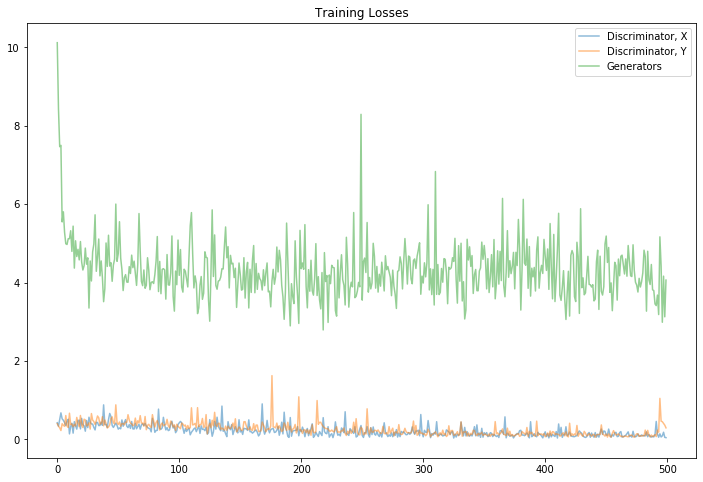

In [0]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

# 8.0 Test

In [0]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')

# view samples at iteration 100
view_samples(5000, 'samples_cyclegan')